In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import psycopg2
import psycopg2.extras
import helper
import seaborn as sns
import calendar
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import style
from datetime import datetime
style.use('ggplot')
import importlib
PLT_FIG_WIDTH = 4.487
PLT_FIG_HEIGHT = PLT_FIG_WIDTH / 1.618
import st_visualizer
import express as viz_express
import geom_helper as viz_helper
import bokeh.palettes as bokeh_palettes
importlib.reload(helper)
importlib.reload(viz_helper)
import psycopg2
import psycopg2.extras

%matplotlib inline

### ΓΝΩΡΙΜΙΑ ΜΕ ΤΑ ΔΕΔΟΜΕΝΑ

In [7]:
%%time
df = pd.read_csv('./data/unipi_kinematic_ais_new.csv', delimiter=';')
df = df.rename(columns={"ts":"timestamp"})

Wall time: 13.3 s


In [8]:
df.head()
# mmsi: μοναδικός κωδικός του πλοίου
# lon, lat: συντεταγμένες του gps σε μοίρες
# speed: ταχύτητα πλοίου, ναυτικά μίλια ανά ώρα, 1 ναυτικό μίλι = 1852 μέτρα
# heading: γωνία σε μοίρες, κατεύθυνση πλόρης καραβιού
# course: γωνία σε μοίρες, πορεία του καραβιού

,timestamp,type,mmsi,status,lon,lat,heading,turn,speed,course
0,1522702656000,NaN,237808200,NaN,23.641833,37.944167,NaN,NaN,0.0,108.0
1,1522702657000,NaN,249226000,NaN,23.680502,37.931003,NaN,NaN,0.0,304.0
2,1522702657000,NaN,377436000,NaN,23.551600,37.955200,NaN,NaN,0.0,129.4
3,1522702658000,NaN,240920000,NaN,23.566252,37.930017,NaN,NaN,0.0,234.1
4,1522702658000,NaN,319101500,NaN,23.669510,37.939548,289.0,NaN,0.1,266.6


In [9]:
%%time
df.sort_values('timestamp', inplace=True)

# δημιουργία γεωμετρίας
df = helper.getGeoDataFrame_v2(df, crs='epsg:4326')

Wall time: 8min 27s


In [10]:
df.head()

,timestamp,type,mmsi,status,lon,lat,heading,turn,speed,course,geom
7571290,1519855200000,NaN,636013190,NaN,23.539338,37.885675,44.0,NaN,1.4,15.5,POINT (23.53934 37.88567)
7571294,1519855201000,NaN,239550200,NaN,23.640850,37.947157,264.0,NaN,0.0,142.1,POINT (23.64085 37.94716)
7571293,1519855201000,NaN,239722800,NaN,23.632205,37.943968,NaN,NaN,0.0,0.0,POINT (23.63220 37.94397)
7571292,1519855201000,NaN,237991700,NaN,23.546150,37.949950,NaN,NaN,0.0,268.0,POINT (23.54615 37.94995)
7571291,1519855201000,NaN,241024000,NaN,23.650097,37.931657,332.0,NaN,0.0,178.1,POINT (23.65010 37.93166)


In [11]:
st_viz = st_visualizer.st_visualizer()
st_viz.set_data(df.head(3000))

viz_express.plot_points_on_map(st_viz, tools=['lasso_select'])
st_viz.add_temporal_filter(temporal_name='timestamp', temporal_unit='ms', callback_policy='value_throttled', step_ms=5*60*10**3, title='Temporal Horizon')
st_viz.show_figures(notebook=True, notebook_url='http://localhost:8888')

Loading BokehJS ...

In [12]:
# πόσα πλοία έχουμε
len(df.mmsi.unique())

1520

In [13]:
# πόσα records και features έχουμε
df.shape

(14587752, 11)

In [14]:
# μέσος όρος σημάτων AIS ανά ημέρα
avg_ais_per_day = df.groupby([pd.to_datetime(df.timestamp,unit="ms").dt.date]).apply(len)

avg_ais_per_day

timestamp
2018-02-28     15780
2018-03-01    243160
2018-03-02    249825
2018-03-03    207502
2018-03-04    143649
               ...  
2018-04-25    324116
2018-04-26    302888
2018-04-27    359620
2018-04-28    318688
2018-04-29    277474
Length: 61, dtype: int64

<AxesSubplot:title={'center':'AIS PER DATE'}, xlabel='timestamp'>

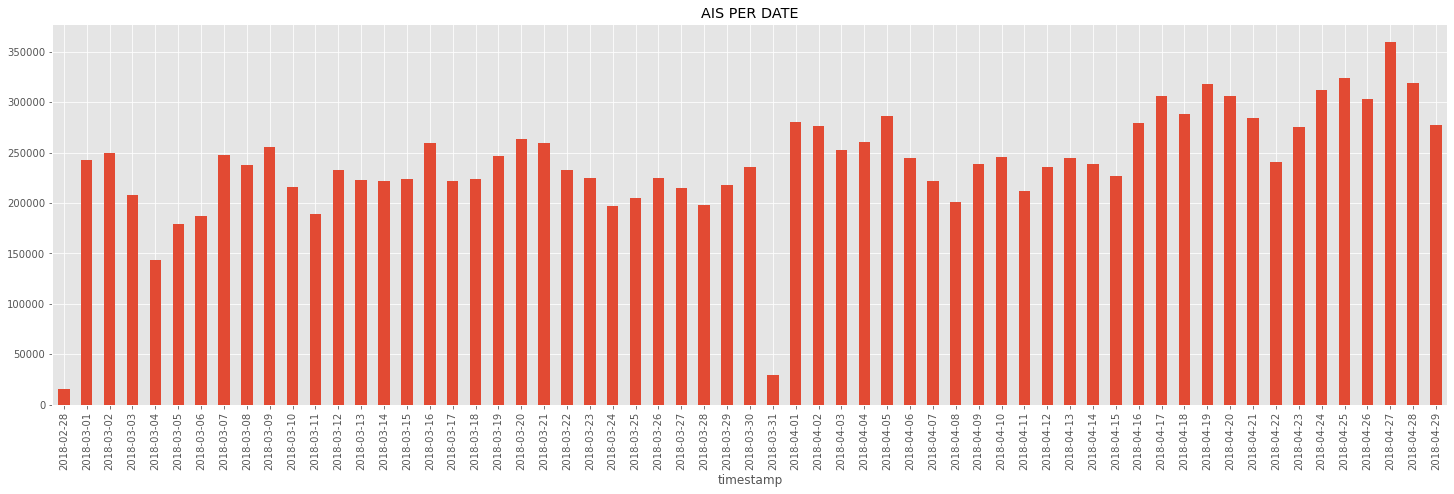

In [15]:
avg_ais_per_day.plot(figsize=(25,7), title="AIS PER DATE", kind='bar')

Text(0, 0.5, '#vessels')

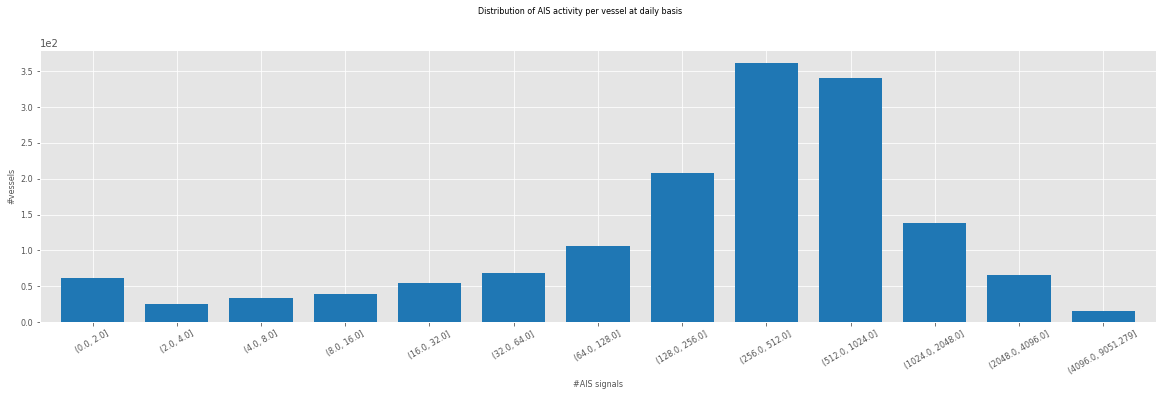

In [16]:
number_of_records_per_vessel_per_day = df.groupby([df.mmsi, pd.to_datetime(df.timestamp, unit='ms').dt.date]).apply(len)
number_of_records_per_vessel_per_day = number_of_records_per_vessel_per_day.groupby('mmsi').apply(lambda x: x.sum()/len(x))

out = pd.cut(number_of_records_per_vessel_per_day, [0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, number_of_records_per_vessel_per_day.max()]) 
ax = out.value_counts(sort=False).plot.bar(figsize=(20,5), fontsize=8, width=0.75, cmap='tab20', rot=30)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.suptitle(r'Distribution of AIS activity per vessel at daily basis', fontsize=8, y=1)
plt.xlabel(r'#AIS signals', fontsize=8)
plt.ylabel(r'#vessels', fontsize=8)

In [17]:
# πληθος σημάτων ανα vessel
avg_ais_per_vessel = df.groupby('mmsi').apply(len)
avg_ais_per_vessel

mmsi
0               26
1193046        132
2411680      12214
24116000       299
24116800      1907
             ...  
970116345        1
970116997        2
982470017       10
982470019        6
999999999    14428
Length: 1520, dtype: int64

<AxesSubplot:title={'center':'AIS PER VESSEL'}, xlabel='mmsi'>

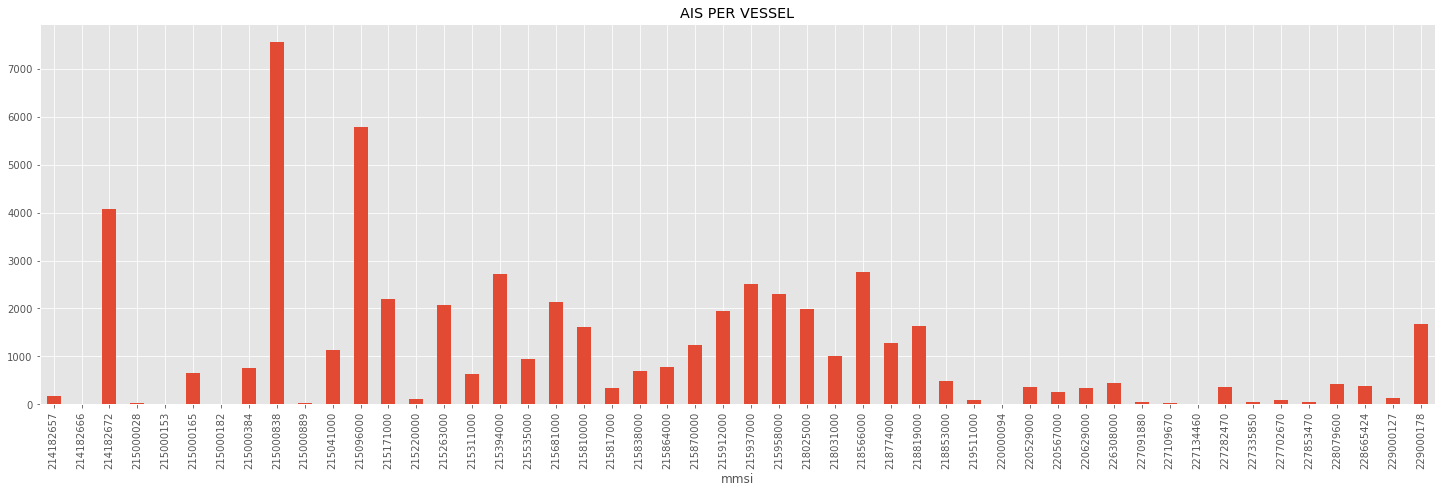

In [18]:
avg_ais_per_vessel[50:100].plot(figsize=(25,7), title="AIS PER VESSEL", kind="bar", )

Text(0, 0.5, '#vessels')

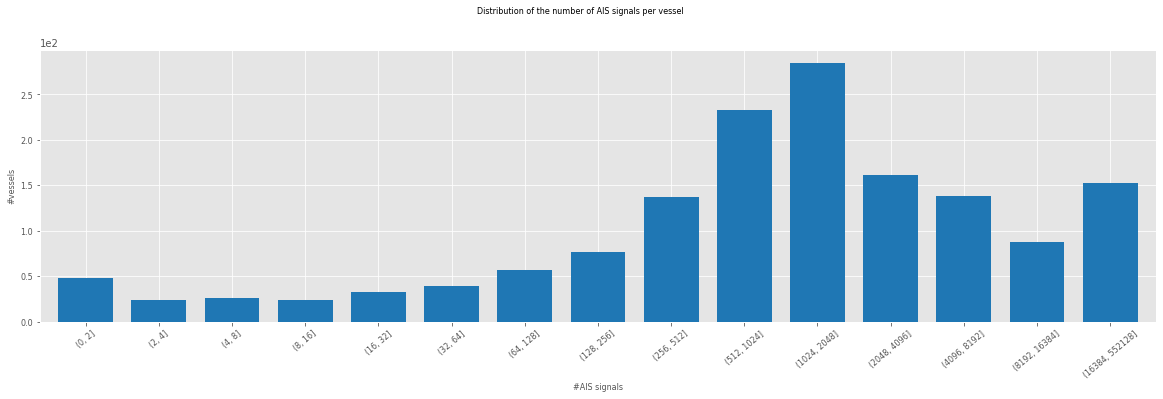

In [19]:
out = pd.cut(avg_ais_per_vessel, [0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, avg_ais_per_vessel.max()]) 
ax = out.value_counts(sort=False).plot.bar(figsize=(20,5), fontsize=8, width=0.75, cmap='tab20', rot=40)


plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.suptitle(r'Distribution of the number of AIS signals per vessel', fontsize=8, y=1)
plt.xlabel(r'#AIS signals', fontsize=8)
plt.ylabel(r'#vessels', fontsize=8)

In [20]:
# μέσος όρος εγγραφών κάθε πλοίου ανά ημέρα
tmp = df.groupby(["mmsi", pd.to_datetime(df.timestamp,unit="ms").dt.date]).apply(len)
print(tmp)

tmp_avg = tmp.groupby('mmsi').apply(lambda x: x.mean())

mmsi       timestamp 
0          2018-03-07      26
1193046    2018-04-10      59
           2018-04-20      73
2411680    2018-04-17    3587
           2018-04-18    6451
                         ... 
999999999  2018-04-21    1835
           2018-04-22    4285
           2018-04-23    1847
           2018-04-24    5251
           2018-04-25    1210
Length: 14918, dtype: int64


In [21]:
tmp_avg

mmsi
0              26.000000
1193046        66.000000
2411680      4071.333333
24116000      299.000000
24116800      476.750000
                ...     
970116345       1.000000
970116997       1.000000
982470017      10.000000
982470019       6.000000
999999999    2885.600000
Length: 1520, dtype: float64

<AxesSubplot:title={'center':'AVERAGE AIS OF VESSEL PER DAY'}, xlabel='mmsi'>

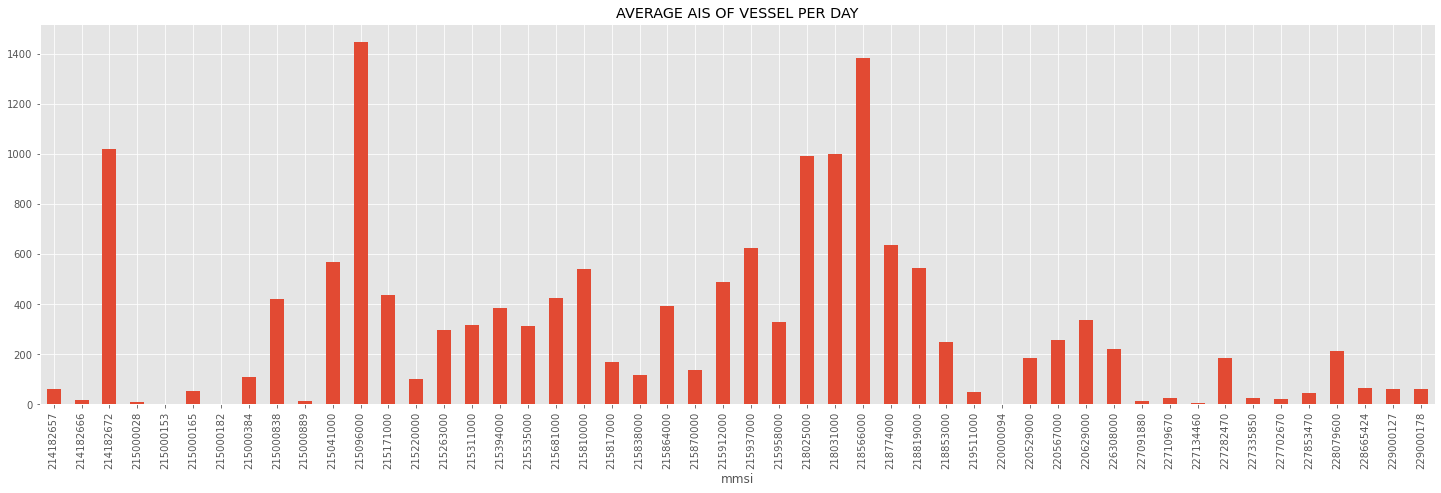

In [22]:
tmp_avg[50:100].plot(figsize=(25,7), title="AVERAGE AIS OF VESSEL PER DAY", kind="bar")

Text(0, 0.5, '#vessels')

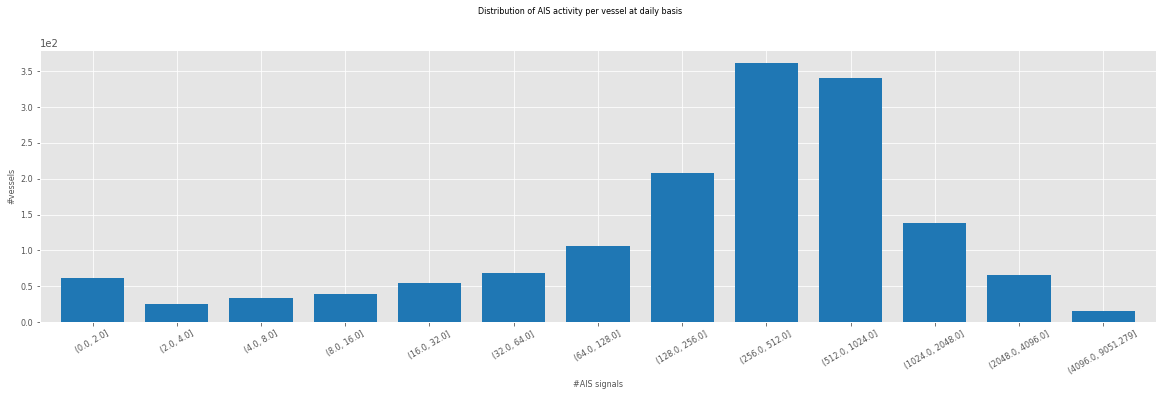

In [23]:
out = pd.cut(tmp_avg, [0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, tmp_avg.max()]) 
ax = out.value_counts(sort=False).plot.bar(figsize=(20,5), fontsize=8, width=0.75, cmap='tab20', rot=30)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.suptitle(r'Distribution of AIS activity per vessel at daily basis', fontsize=8, y=1)
plt.xlabel(r'#AIS signals', fontsize=8)
plt.ylabel(r'#vessels', fontsize=8)

In [24]:
# πληθος AIS σημάτων ανά ημέρα

# κανουμε group by με βαση το date, το μετατρέπουμε απο series σε frame και κα΄νουμε reset index στο αρχικό
recs_per_dayname = df.groupby([pd.to_datetime(df.timestamp, unit="ms").dt.date]).apply(len).to_frame().reset_index()

# προσθέτουμε ενα extra column day_name
recs_per_dayname.loc[:, 'day_name'] = pd.to_datetime(recs_per_dayname.timestamp).dt.day_name()

# κατηγοριοποιούμε τις ημερες και τις κάνουμε order σύφμωνα με την σωστή διάταξη
recs_per_dayname.loc[:, 'day_name'] = pd.Categorical(recs_per_dayname.day_name, categories=list(calendar.day_name), ordered=True)

In [25]:
recs_per_dayname.head()

,timestamp,0,day_name
0,2018-02-28,15780,Wednesday
1,2018-03-01,243160,Thursday
2,2018-03-02,249825,Friday
3,2018-03-03,207502,Saturday
4,2018-03-04,143649,Sunday


Text(0, 0.5, '#records')

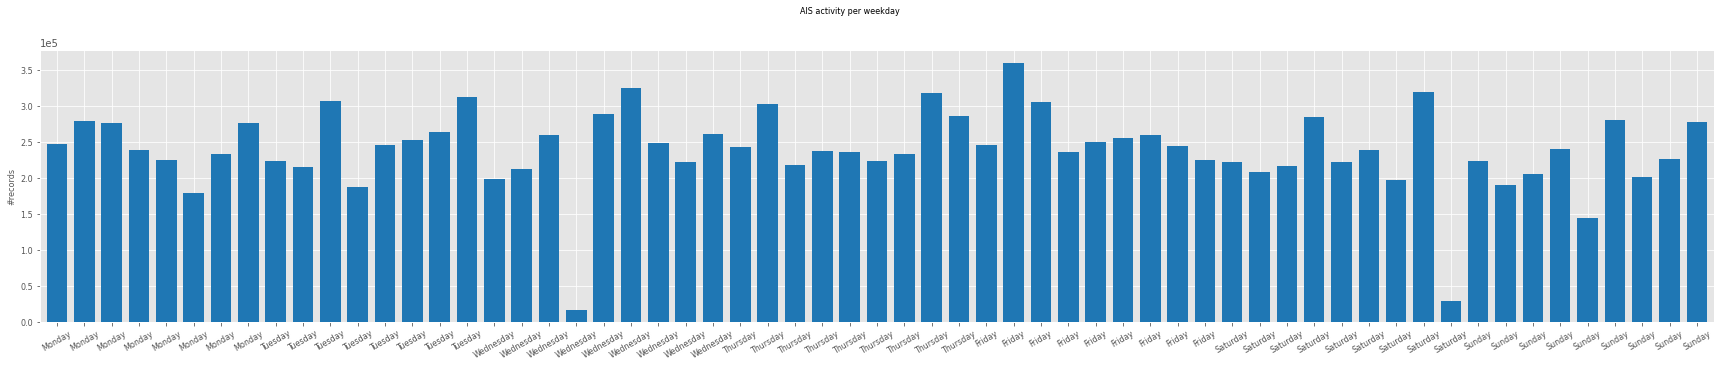

In [26]:
recs_per_dayname.sort_values('day_name', inplace=True)

recs_per_dayname.plot.bar(cmap='tab20', x='day_name', figsize=(30,5), fontsize=8, width=0.75, legend=False, rot=30)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.suptitle(r'AIS activity per weekday', fontsize=8, y=1)
plt.xlabel(r'', fontsize=8)
plt.ylabel(r'#records', fontsize=8)

### ΚΑΘΑΡΙΣΜΟΣ ΔΕΔΟΜΕΝΩΝ

In [27]:
def preprocessing_pipeline(df):
    # Converting time from msec. to sec.
    df.loc[:, 'timestamp_sec'] = df.timestamp/10**3

    # Remove duplicate points
    df.drop_duplicates(subset=['timestamp','mmsi'], inplace=True)

    print ('Step 1. Calculating Speed')
    # Calculate speed
    calc_velocity = df.copy().groupby('mmsi', group_keys=False).apply(lambda gdf: helper.calculate_velocity(gdf, spd_column='speed', ts_column='timestamp_sec'))['velocity']

    print ('Step 2. Calculating Bearing')
    # Calculate bearing
    calc_heading = df.copy().groupby('mmsi', group_keys=False).apply(lambda gdf: helper.calculate_bearing(gdf))['bearing']

    print ('Step 3. Concatenating Results')
    df.loc[:, 'velocity'] = calc_velocity
    df.loc[:, 'bearing'] = calc_heading

    print ('Step 4. Calculating Acceleration')
    # Calculate acceleration
    df = df.groupby('mmsi', group_keys=False).apply(lambda gdf: helper.calculate_acceleration(gdf, ts_column='timestamp_sec'))

    # Drop NaN values (in case they exist)
    df.dropna(subset=['velocity', 'bearing', 'acceleration'], inplace=True)
    
    return df

In [28]:
%%time
df = preprocessing_pipeline(df.copy())

Step 1. Calculating Speed
Step 2. Calculating Bearing
Step 3. Concatenating Results
Step 4. Calculating Acceleration
Wall time: 1h 10min 20s


In [29]:
df.head()

,timestamp,type,mmsi,status,lon,lat,heading,turn,speed,course,geom,timestamp_sec,velocity,bearing,acceleration
7571290,1519855200000,NaN,636013190,NaN,23.539338,37.885675,44.0,NaN,1.4,15.5,POINT (23.53934 37.88567),1.519855e+09,1.384017,24.892345,-0.019672
7571294,1519855201000,NaN,239550200,NaN,23.640850,37.947157,264.0,NaN,0.0,142.1,POINT (23.64085 37.94716),1.519855e+09,0.265630,77.088586,-0.016206
7571293,1519855201000,NaN,239722800,NaN,23.632205,37.943968,NaN,NaN,0.0,0.0,POINT (23.63220 37.94397),1.519855e+09,0.092528,108.961741,0.002525
7571292,1519855201000,NaN,237991700,NaN,23.546150,37.949950,NaN,NaN,0.0,268.0,POINT (23.54615 37.94995),1.519855e+09,0.000000,0.000000,0.000000
7571291,1519855201000,NaN,241024000,NaN,23.650097,37.931657,332.0,NaN,0.0,178.1,POINT (23.65010 37.93166),1.519855e+09,0.154236,108.908983,0.006314


C:\anaconda3\envs\gis\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0, 0.5, '#records')

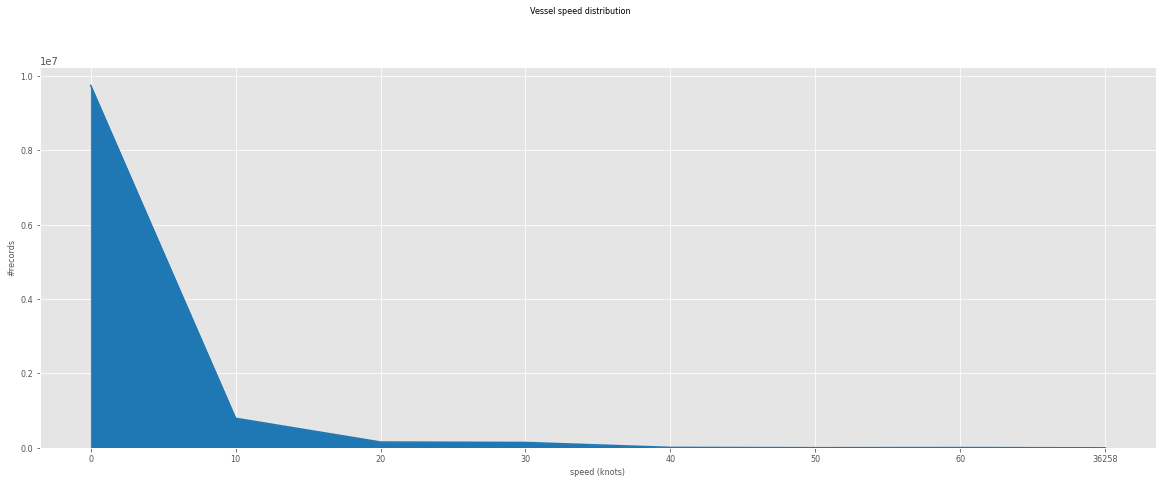

In [30]:
out = pd.cut(df.velocity, [0, 10, 20, 30, 40, 50, 60, np.round(df.velocity.max()), np.round(df.velocity.max())+2])
ax = out.value_counts(sort=False).plot.area(figsize=(20,7), fontsize=8, cmap='tab20', rot=0)
ax.set_xticklabels([''] + out.cat.categories.left.values.astype(int).tolist() + [''])

plt.suptitle(r'Vessel speed distribution', fontsize=8, y=1)
plt.xlabel(r'speed (knots)', fontsize=8)
plt.ylabel(r'#records', fontsize=8)

C:\anaconda3\envs\gis\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0, 0.5, '#records')

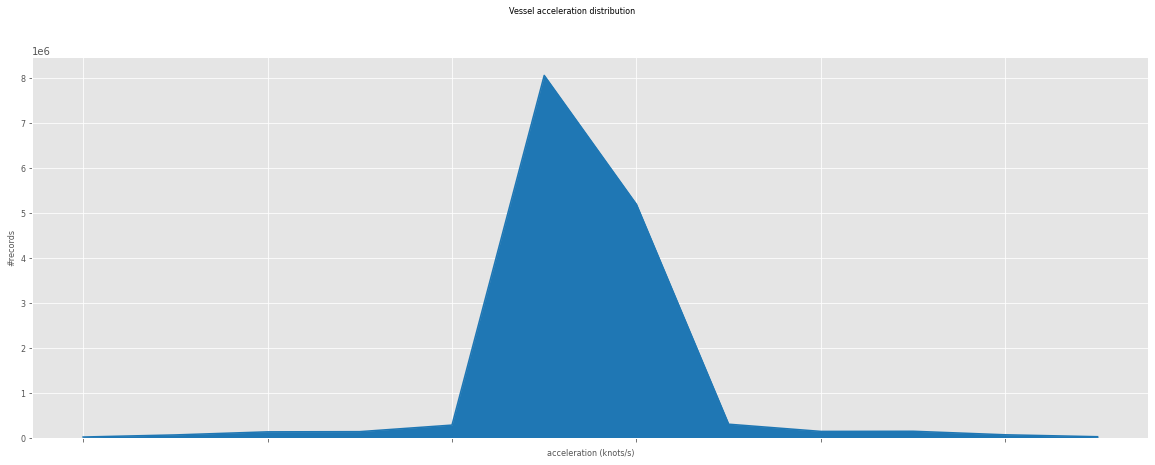

In [32]:
no_of_bins=[-2000, -10, -2, -0.5, -0.25, -0.1, 0, 0.1, 0.25, 0.5, 2, 10, 2000] 

out = pd.cut(df.acceleration, no_of_bins)
ax = out.value_counts(sort=False).plot.area(figsize=(20,7), fontsize=8, cmap='tab20', rot=45)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.suptitle(r'Vessel acceleration distribution', fontsize=8)
plt.xlabel(r'acceleration (knots/s)', fontsize=8)
plt.ylabel(r'#records', fontsize=8)

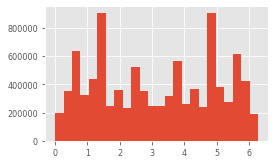

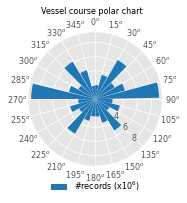

In [33]:
PLT_FIG_WIDTH = 4
PLT_FIG_HEIGHT = PLT_FIG_WIDTH / 1.618
plt.rcParams.update({'font.size': 8})
plt.rcParams["figure.figsize"] = [PLT_FIG_WIDTH, PLT_FIG_HEIGHT]

bins_number = 24  # the [0, 360) interval will be subdivided into this number of equal bins
degree_intervals = 15

fig, ax = plt.subplots()
ax, lines, labels = helper.create_radial_chart(ax, df, bins_number, degree_intervals)

ax.legend([r'#records (x$10^6$)'], frameon=False, fancybox=False, shadow=False, loc='lower center', bbox_to_anchor=(0.5, -0.25))

plt.show()

In [34]:
# checkpoint
df.drop(['geom'], axis=1).to_csv('./data/unipi_ais_pp.csv', header=True, index=False)

In [35]:
df = helper.getGeoDataFrame_v2(pd.read_csv('./data/unipi_ais_pp.csv'), crs='epsg:4326')

In [36]:
df_new = df.loc[df.velocity < 40].copy()

In [37]:
df_new

,timestamp,type,mmsi,status,lon,lat,heading,turn,speed,course,timestamp_sec,velocity,bearing,acceleration,geom
0,1519855200000,NaN,636013190,NaN,23.539338,37.885675,44.0,NaN,1.4,15.5,1.519855e+09,1.384017,24.892345,-0.019672,POINT (23.53934 37.88567)
1,1519855201000,NaN,239550200,NaN,23.640850,37.947157,264.0,NaN,0.0,142.1,1.519855e+09,0.265630,77.088586,-0.016206,POINT (23.64085 37.94716)
2,1519855201000,NaN,239722800,NaN,23.632205,37.943968,NaN,NaN,0.0,0.0,1.519855e+09,0.092528,108.961741,0.002525,POINT (23.63220 37.94397)
3,1519855201000,NaN,237991700,NaN,23.546150,37.949950,NaN,NaN,0.0,268.0,1.519855e+09,0.000000,0.000000,0.000000,POINT (23.54615 37.94995)
4,1519855201000,NaN,241024000,NaN,23.650097,37.931657,332.0,NaN,0.0,178.1,1.519855e+09,0.154236,108.908983,0.006314,POINT (23.65010 37.93166)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14568237,1525035585000,NaN,239923000,NaN,23.641367,37.947917,180.0,NaN,0.0,42.0,1.525036e+09,0.000000,0.000000,0.000000,POINT (23.64137 37.94792)
14568238,1525035587000,NaN,237008100,NaN,23.641020,37.944862,NaN,NaN,0.0,NaN,1.525036e+09,0.120081,0.000000,0.040027,POINT (23.64102 37.94486)
14568239,1525035588000,NaN,636017894,NaN,23.594718,37.956058,166.0,NaN,0.0,0.1,1.525036e+09,0.367175,193.592832,0.043390,POINT (23.59472 37.95606)
14568240,1525035588000,NaN,240370000,NaN,23.668000,37.937900,256.0,NaN,0.0,18.0,1.525036e+09,0.000000,0.000000,0.000000,POINT (23.66800 37.93790)


In [38]:
# πριν ηταν 1520
df_new.mmsi.nunique()

1504

In [33]:
# df_new.to_csv('./data/unipi_ais_clean_geom.csv', header=True, index=False)

In [39]:
df_new.drop(df_new.geometry.name, axis=1).to_csv('./data/unipi_ais_clean.csv', header=True, index=False)

In [40]:
# παλιο shape (14587752, 11)
df_new.shape

(14546856, 15)

In [41]:
df_new.head()

,timestamp,type,mmsi,status,lon,lat,heading,turn,speed,course,timestamp_sec,velocity,bearing,acceleration,geom
0,1519855200000,NaN,636013190,NaN,23.539338,37.885675,44.0,NaN,1.4,15.5,1.519855e+09,1.384017,24.892345,-0.019672,POINT (23.53934 37.88567)
1,1519855201000,NaN,239550200,NaN,23.640850,37.947157,264.0,NaN,0.0,142.1,1.519855e+09,0.265630,77.088586,-0.016206,POINT (23.64085 37.94716)
2,1519855201000,NaN,239722800,NaN,23.632205,37.943968,NaN,NaN,0.0,0.0,1.519855e+09,0.092528,108.961741,0.002525,POINT (23.63220 37.94397)
3,1519855201000,NaN,237991700,NaN,23.546150,37.949950,NaN,NaN,0.0,268.0,1.519855e+09,0.000000,0.000000,0.000000,POINT (23.54615 37.94995)
4,1519855201000,NaN,241024000,NaN,23.650097,37.931657,332.0,NaN,0.0,178.1,1.519855e+09,0.154236,108.908983,0.006314,POINT (23.65010 37.93166)


C:\anaconda3\envs\gis\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0, 0.5, '#records')

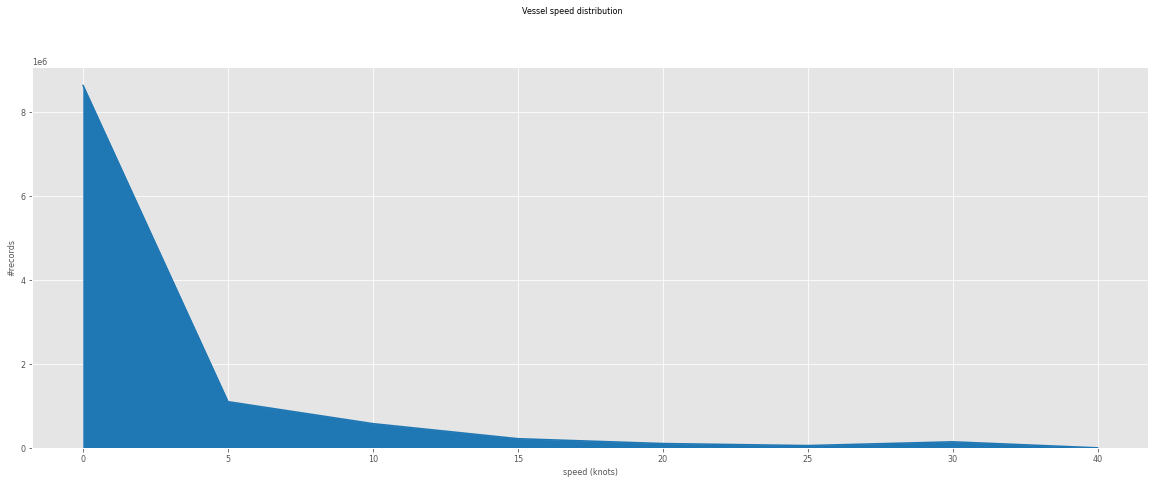

In [42]:
out = pd.cut(df_new.velocity, [0, 5, 10, 15, 20, 25, 30, np.round(df_new.velocity.max()), np.round(df_new.velocity.max())+2])
ax = out.value_counts(sort=False).plot.area(figsize=(20,7), fontsize=8, cmap='tab20', rot=0)
ax.set_xticklabels([''] + out.cat.categories.left.values.astype(int).tolist() + [''])

plt.suptitle(r'Vessel speed distribution', fontsize=8, y=1)
plt.xlabel(r'speed (knots)', fontsize=8)
plt.ylabel(r'#records', fontsize=8)